# **ResNet-18 Model**

El modelo empleado corresponde a una variante **ResNet-18 en configuración 2.5D**, diseñada para aprovechar información espacial proveniente de múltiples cortes axiales de resonancia magnética sin incurrir en el costo computacional ni en los requerimientos de datos de una red 3D completa. Para cada sujeto se seleccionan *N* cortes contiguos del volumen, tomados de forma equidistante con el fin de capturar información anatómica representativa. Cada slice se trata como una imagen 2D, pero el modelo recibe una pila multicanal donde cada canal corresponde a un corte distinto, preservando así la continuidad estructural a lo largo del eje Z.

Esta pila de cortes pasa luego por las capas convolucionales de ResNet-18, donde los bloques residuales permiten extraer características profundas de forma estable. Gracias al apilamiento 2.5D, la red aprende no solo patrones dentro de cada slice (información in-plane), sino también relaciones entre cortes adyacentes (información through-plane), lo que resulta esencial para detectar alteraciones sutiles distribuidas en distintas secciones del cerebro. Finalmente, un global average pooling seguido de una capa totalmente conectada produce la probabilidad de demencia, es decir, el modelo captura la información mediante apilamiento directo de slices. Se denomina 2.5D porque integra parte de la información volumétrica sin ejecutar convoluciones 3D: opera con convoluciones 2D puras, pero sobre entradas multicanal que representan el volumen de forma aproximada.

El trabajo de [Amarjeet Kumar et al. (2024)](https://www.sciencedirect.com/science/article/pii/S0010482524012587) propone **CSA-Net**, un enfoque más avanzado dentro de la familia 2.5D. Aunque su tarea es la segmentación y la nuestra la clasificación, ambos comparten el principio de procesar volúmenes con alta resolución in-plane y menor resolución through-plane, una estructura típica en neuroimágenes clínicas. En términos simples, esto significa que dentro de cada corte axial se observa gran detalle anatómico (X-Y), pero entre cortes la continuidad es limitada debido al mayor espesor y a la distancia entre ellos (Z).

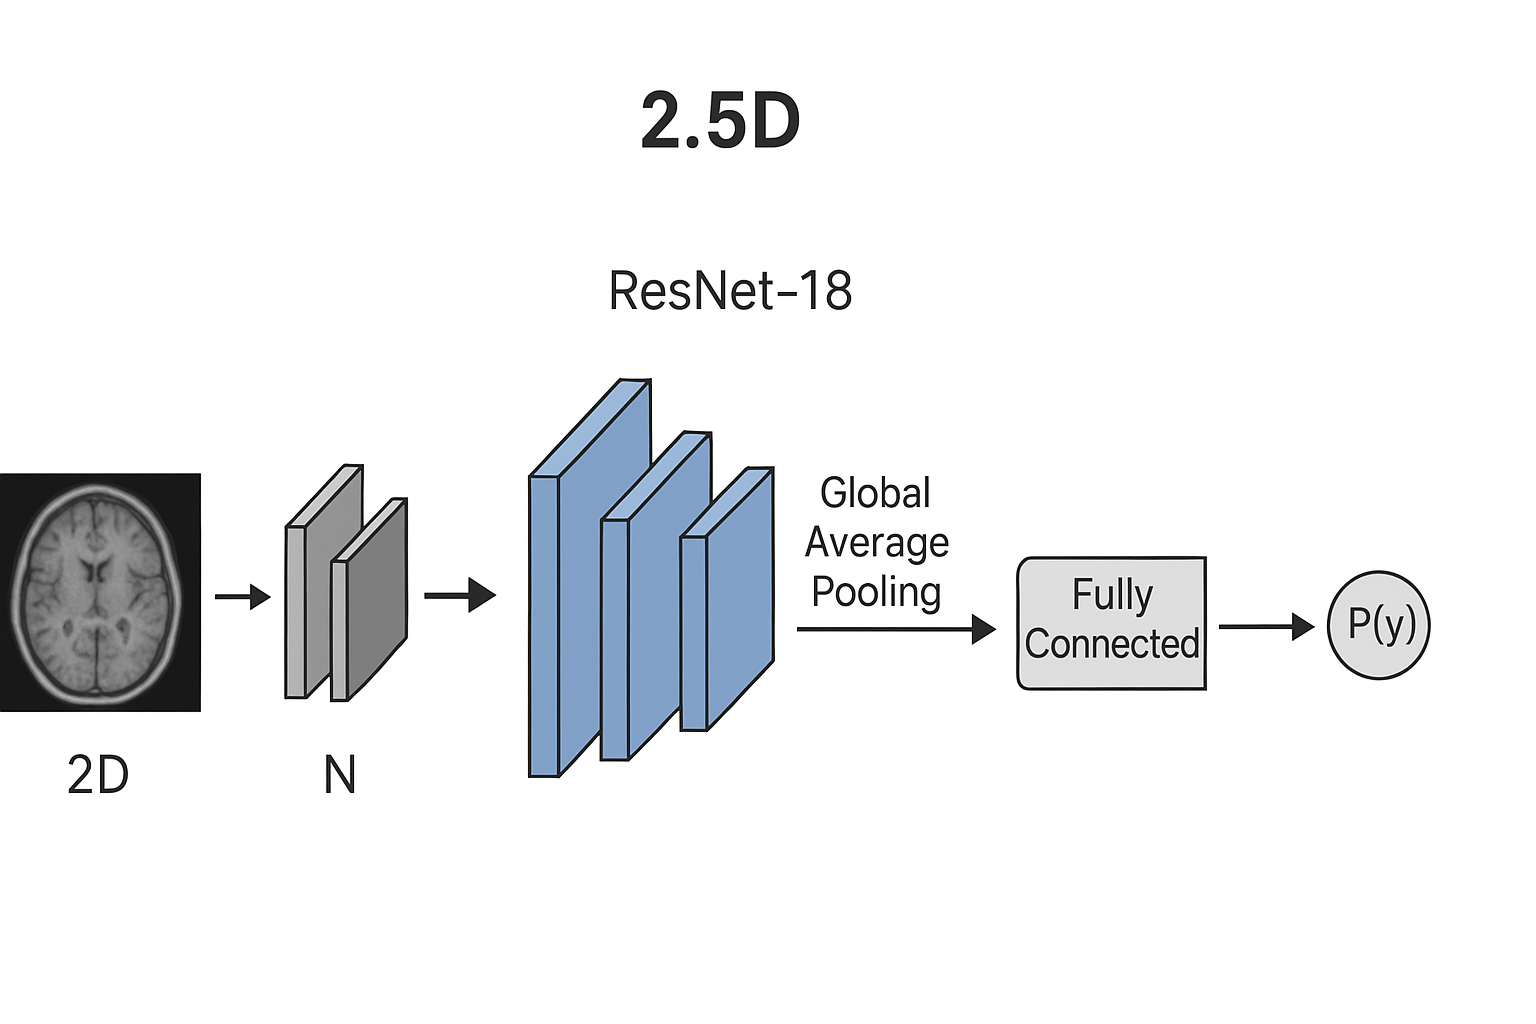

In [ ]:
# [] Librerias
# ==== Standard Libraries ====
import os, time, warnings

# ==== Scientific & Data Handling ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== PyTorch Core ====
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from torchvision.models import resnet18

# ==== ML & Evaluation ====
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score
)
from sklearn.utils import resample
from statsmodels.stats.proportion import proportions_ztest

# ==== Utilities ====
from tqdm import tqdm
import itertools

# ==== Reproducibility ====
SEED = 42

# ==== Device Handling (DirectML + fallback CPU) ====
try:
    import torch_directml
    DEVICE = torch_directml.device()
    print("Using DirectML device:", DEVICE)
except Exception as e:
    DEVICE = torch.device("cpu")
    print("DirectML no disponible. Usando CPU:", e)

# ==== Warnings ====
warnings.filterwarnings('ignore')

Using DirectML device: privateuseone:0


In [ ]:
# [] DATA path
CSV_PATH = '../Data/Tabular.csv'
FOLDER_PATH = r"C:\Users\usuario\MRI\IMAGES_npy"

OUTPUT_DIR = "../Models_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# [] Atributos de las imégenes
shapes, means, stds, size = [], [], [], []

for f in os.listdir(FOLDER_PATH):
    if f.endswith(".npy"):
        img = np.load(os.path.join(FOLDER_PATH, f))
        shapes.append(img.shape)
        means.append(img.mean())
        stds.append(img.std())
        size.append(img.size)

# Contar shapes únicos
shapes_unicos = set(shapes)
size_unicos = set(size)
print("Shapes únicos encontrados:", shapes_unicos)
print("Total de imágenes:", len(shapes))
print(f"Media global promedio: {np.mean(means):.4f}")
print(f"Desviación global promedio: {np.mean(stds):.4f}")
print(f"Size únicos: {size_unicos}")

Shapes únicos encontrados: {(160, 192, 192)}
Total de imágenes: 220
Media global promedio: 0.0000
Desviación global promedio: 1.0000
Size únicos: {5898240}


In [ ]:
# [] LOAD CSV
# ============================
df = pd.read_csv(CSV_PATH, dtype={'sujeto_id': str})
df = df.dropna(subset=['is_dementia'])

df['sujeto_id'] = df['sujeto_id'].astype(str).str.strip()
df['imagen_id'] = df['imagen_id'].astype(str).str.strip()

# FULL FILE PATH
def build_path(row):
    filename = f"{row['sujeto_id']}_{row['imagen_id']}.npy"
    return os.path.join(FOLDER_PATH, filename)

df['file_path'] = df.apply(build_path, axis=1)

df = df[['file_path', 'sujeto_id', 'is_dementia']].rename(
    columns={'is_dementia': 'label'}
)


In [ ]:
# [] Distribución básica de is_dementia

class_distribution = df['label'].value_counts().sort_index()
print("=== DISTRIBUCIÓN DE CLASES ===")
print(f"Clase 0 (No Dementia): {class_distribution.get(0, 0)} imágenes - {class_distribution.get(0, 0)/len(df)*100:.2f}%")
print(f"Clase 1 (Dementia): {class_distribution.get(1, 0)} imágenes - {class_distribution.get(1, 0)/len(df)*100:.2f}%")
class_distribution = df['label'].value_counts().sort_index()
N = len(df)
count_dementia = class_distribution.get(1, 0)
expected_proportion = 0.5 
z_stat, p_value = proportions_ztest(count=count_dementia, 
                                    nobs=N, 
                                    value=expected_proportion, 
                                    alternative='two-sided')
print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_value:.4e}")
# Conclusión
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusión: Se rechaza H0. La proporción de la Clase 1 ({count_dementia/N*100:.2f}%) es SIGNIFICATIVAMENTE diferente de {expected_proportion*100:.0f}%.")
else:
    print(f"\nConclusión: No se rechaza H0. No hay evidencia suficiente para decir que la proporción es diferente de {expected_proportion*100:.0f}%.")

=== DISTRIBUCIÓN DE CLASES ===
Clase 0 (No Dementia): 158 imágenes - 71.82%
Clase 1 (Dementia): 62 imágenes - 28.18%
Estadístico Z: -7.1933
Valor p: 6.3244e-13

Conclusión: Se rechaza H0. La proporción de la Clase 1 (28.18%) es SIGNIFICATIVAMENTE diferente de 50%.


In [ ]:
# [PASO 1] Group stratified split
def group_stratified_split(records):
    """
    Split estratificado por SUJETO:
        Train 60%
        Val   20%
        Test  20%
    Sin fuga de información.
    """

    df_local = pd.DataFrame(records)

    # 1. Etiqueta por sujeto (promedio -> entero)
    subj_lab = df_local.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))
    subjects = subj_lab.index.to_list()
    y = subj_lab.values

    # -----------------------------
    # 2. Train (60%) vs Resto (40%)
    # -----------------------------
    gss1 = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=SEED)
    train_idx, rest_idx = next(gss1.split(subjects, y, groups=subjects))

    train_subj = [subjects[i] for i in train_idx]
    rest_subj  = [subjects[i] for i in rest_idx]

    # -----------------------------
    # 3. Val (20%) vs Test (20%) dentro del 40%
    # -----------------------------
    rest_labels = [subj_lab[s] for s in rest_subj]

    val_subj, test_subj = train_test_split(
        rest_subj,
        test_size=0.5,
        random_state=SEED,
        stratify=rest_labels
    )

    # -----------------------------
    # 4. Regresar DataFrames
    # -----------------------------
    def pick(subjects_list):
        return df_local[df_local["sujeto_id"].isin(subjects_list)].reset_index(drop=True)

    return pick(train_subj), pick(val_subj), pick(test_subj)


In [8]:
# [PASO 2] Construcción del DataSet MRI 2.5D
# ---------------------------

class MRI2p5DDataset(Dataset):
    def __init__(self, df, n_slices, target_size=(224,224), augment=False):
        """
        df: DataFrame con columnas 'file_path' y 'label'
        n_slices: número de cortes a tomar por volumen
        target_size: tamaño HxW de las imágenes
        augment: aplicar data augmentation
        """
        self.records = df.to_dict("records")
        self.n_slices = n_slices
        self.target_size = target_size
        self.augment = augment

        # Transforms
        self.augment_tf = T.Compose([
            T.RandomRotation(10),
            T.RandomResizedCrop(target_size, scale=(0.9,1.0))
        ])
        self.base_tf = T.Compose([
            T.Resize(target_size),
            T.ToTensor()
        ])
        
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, idx):
        rec = self.records[idx]
        vol = np.load(rec["file_path"])  # (D,H,W) 3D array, Cortes-Altura-Ancho

        # Elegir n_slices uniformemente
        D = vol.shape[0]
        idxs = np.linspace(0, D-1, self.n_slices).astype(int)
        slices = vol[idxs]  # (n_slices,H,W)

        # Convertir cada slice a tensor
        imgs = []
        for s in slices:
            # Normalizar a [0,255] y convertir a PIL
            s_img = ((s - s.min())/(s.max()-s.min()+1e-6) * 255).astype(np.uint8)
            img = Image.fromarray(s_img).convert("L")  # 1 canal
            if self.augment:
                img = self.augment_tf(img)
            img = self.base_tf(img)  # (1,H,W)
            imgs.append(img)
        
        # Apilar slices como canales -> (n_slices,H,W)
        input_tensor = torch.cat(imgs, dim=0)
        
        label = torch.tensor(rec["label"], dtype=torch.float32)
        return input_tensor, label

In [9]:
# [PASO 3] Modelo ResNet18 MRI 2.5D
# ---------------------------

class ResNet18_2p5D(nn.Module):
    """
    Modelo 2.5D basado en ResNet18 para clasificación binaria de volúmenes 3D (MRI). 
    
    Idea clave:
    - Cada volumen 3D se divide en 'n_slices' cortes (slices) uniformes.
    - Los slices se apilan como canales de una imagen 2D de entrada.
    - La ResNet18 procesa todos los slices simultáneamente como una "imagen 2D con n_slices canales".
    - La salida es un logit único por volumen, útil para predecir probabilidad de progresión de Alzheimer.

    Parámetros
    ----------
    n_slices : int
        Número de cortes (slices) que se apilan como canales de entrada.
        Por defecto: 32.
    """

    def __init__(self, n_slices):
        super().__init__()

        # Base ResNet18 sin pesos preentrenados
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(
            in_channels=n_slices,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512,1)
        )

    def forward(self, x):
        """
        Forward pass del modelo.

        Parámetros
        ----------
        x : torch.Tensor
            Tensor de entrada de forma (B, n_slices, H, W)
            donde B = batch size, n_slices = número de slices apilados,
            H y W = dimensiones espaciales de cada slice.

        Retorna
        -------
        logits : torch.Tensor
            Tensor de forma (B,), logit único por volumen.
            Este logit se puede pasar a sigmoid para obtener probabilidad.
        """
        # x: (B, n_slices, H, W)
        logits = self.model(x)  # ResNet18 produce (B,1)
        return logits.squeeze(1)  # Redimensiona a (B,)


In [10]:
# [PASO 4] Entrenamiento por epoca y evaluacion
# ---------------------------

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()                    # Coloca el modelo en modo entrenamiento
    total_loss = 0
    total = 0
    pbar = tqdm(loader, desc="Train", leave=False)
    
    for X, y in pbar:
        X, y = X.to(device), y.to(device)  # Enviar batch a GPU/CPU
        optimizer.zero_grad()              # Reiniciar gradientes

        logits = model(X)                  # Forward
        loss = criterion(logits, y)        # Calcular pérdida
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Actualizar pesos

        total_loss += loss.item() * y.size(0)  # Acumular pérdida ponderada por batch
        total += y.size(0)
        pbar.set_postfix({"batch_loss": loss.item()})  # Mostrar pérdida por batch

    return total_loss / total  # Pérdida promedio por sample

def evaluate(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            logits = model(images)
            prob = torch.sigmoid(logits).cpu().numpy().flatten()
            pred = (prob >= 0.5).astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred)
            all_probs.extend(prob)

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    recall = recall_score(all_labels, all_preds)

    return acc, bal_acc, auc, recall


In [ ]:
# [PASO 5] Preparación de dataloaders
def prepare_dataloaders(df, batch_size, n_slices, target_size=(224,224)):
    records = df.to_dict("records")

    # -------- SPLIT POR SUJETO (60/20/20) --------
    train_df, val_df, test_df = group_stratified_split(records)

    #print(f"Dimensiones: Train {len(train_df)} | Val {len(val_df)} | Test {len(test_df)}")

    # ========== CALCULAR CLASE PREDOMINANTE POR SUJETO ==========
    subj_lab = train_df.groupby("sujeto_id")["label"].agg(lambda x: int(round(x.mean())))

    #print("\n=== Etiqueta predominante por sujeto (Train) ===")
    #print(subj_lab.value_counts())

    # Sujetos mayoritarios/minoritarios según la etiqueta predominante
    maj_subj = subj_lab[subj_lab == 0].index.tolist()
    min_subj = subj_lab[subj_lab == 1].index.tolist()

    #print(f"Sujetos clase 0 (majority): {len(maj_subj)}")
    #print(f"Subjects clase 1 (minority): {len(min_subj)}")

    # ========== UPSAMPLING A NIVEL DE SUJETO ==========
    min_subj_upsampled = resample(
        min_subj,
        replace=True,
        n_samples=len(maj_subj),
        random_state=42
    )

    #print("\nSujetos repetidos en oversampling:")
    #print(pd.Series(min_subj_upsampled).value_counts())

    # ========== RECONSTRUIR TRAIN BALANCEADO SIN MODIFICAR VISITAS ==========
    train_df_bal = pd.concat([
        train_df[train_df["sujeto_id"].isin(maj_subj)],
        train_df[train_df["sujeto_id"].isin(min_subj_upsampled)]
    ]).sample(frac=1, random_state=42)

    #print("\n=== Distribución después de oversampling (por imagen) ===")
    #print(train_df_bal["label"].value_counts())

    # ========== DATASETS ==========
    train_dataset = MRI2p5DDataset(train_df_bal, n_slices=n_slices,
                                   target_size=target_size, augment=True)
    val_dataset   = MRI2p5DDataset(val_df, n_slices=n_slices,
                                   target_size=target_size, augment=False)
    test_dataset  = MRI2p5DDataset(test_df, n_slices=n_slices,
                                   target_size=target_size, augment=False)

    # ========== DATALOADERS ==========
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size)

    #print(f"\nTrain Loader: {len(train_loader.dataset)} ejemplos, {len(train_loader)} batches")
    #print(f"Validation Loader: {len(val_loader.dataset)} ejemplos, {len(val_loader)} batches")
    #print(f"Test Loader: {len(test_loader.dataset)} ejemplos, {len(test_loader)} batches")

    return train_loader, val_loader, test_loader


In [12]:
# [PASO 6] Modulo de entrenamiento
# ---------------------------
def train_model(
        model, train_loader, val_loader, device, 
        epochs, lr, weight_decay, early_stopping_patience, model_ej):
    """
    Entrena el modelo y retorna listas de pérdidas y métricas.
    """
    print(f"\n⏺️ Épocas {epochs} | LR-WD {lr}-{ weight_decay} | Patience {early_stopping_patience}")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_losses, val_recalls, val_aucs, val_bac = [], [], [], []
    best_bal_acc = 0
    patience_counter = 0

    print("▶️ Start train")
    time_all = time.time()

    for ep in range(epochs):
        time_ep = time.time()
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        time_train = time.time() - time_ep
        acc, bal_acc, auc, recall = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_recalls.append(recall)
        val_aucs.append(auc)
        val_bac.append(bal_acc)

        #print(f"Epoch {ep+1}/{epochs} | TrainLoss={train_loss:.4f} ||"
           #   f"BAC ={bal_acc:.4f} | Recall ={recall:.4f} | "
           #   f"AUC={auc:.4f} | Time={time_train/60:.2f}")
        # Scheduler
        scheduler.step(train_loss)

        # EARLY STOPPING usando RECALL DE LA CLASE 1
        if bal_acc > best_bal_acc:  # Considera ambas clases
            best_bal_acc = bal_acc
            patience_counter = 0
            model_path = f"../Models_Output/{model_ej}_{epochs}_{ep}_{early_stopping_patience}.pth"
            torch.save(model.state_dict(), model_path)
            print(f">> Mejor modelo guardado"
                  f"Epoch {ep+1}/{epochs} | TrainLoss={train_loss:.4f} ||"
                  f"BAC ={bal_acc:.4f} | Recall ={recall:.4f} | "
                  f"AUC={auc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f">> Early stopping activado {ep}")
                break

    
    print(f"Tiempo total de entrenamiento: {(time.time() - time_all)/60:.2f} minutos")
    return train_losses, val_bac, val_aucs, model_path

In [ ]:
# [PASO 7] Evaluación final
def evaluate_final(model, test_loader, device, model_path):
    """
    Evalúa el mejor modelo guardado y calcula métricas relevantes,
    incluyendo sensibilidad (recall de clase positiva) y especificidad.
    """
    print(f"Best model: {model_path}")
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = (all_preds == all_labels).float().mean().item()
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')

    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\n TEST =====")

    print(f"BAC = {bal_acc:.4f} | AUC = {auc:.4f} | recall = {recall:.4f}  | f1 = {f1:.4f}")
    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    print("\nMatriz de confusión:")
    print(cm)

    # Reporte de clasificación
    report = classification_report(all_labels, all_preds, target_names=["No Dementia", "Dementia"])
    print("\nReporte de clasificación:")
    print(report)

    return acc, bal_acc, auc, recall, f1, cm, report


In [ ]:
# MAIN
# ---------------------------
def main(df, device, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO):
    print(F"✳️ Entrenando modelo {MODELO}")
    train_loader, val_loader, test_loader = prepare_dataloaders(df, BATCH, n_slices)

    model = ResNet18_2p5D(n_slices).to(device)
    
    train_losses, val_bac, val_aucs, model_path = train_model(
        model, train_loader, val_loader, device, 
        EPOCHS, LR, WEIGHT, EARLY, MODELO)
        
    # Evaluación final
    evaluate_final(model, test_loader, device, model_path)

-----------------

## Primer tuning
Ejecuciones por slices

In [ ]:
# Parámetros fijos: 
EPOCHS = 20 
EARLY = 3

# Definir los rangos de LR y WEIGHT
LR_RANGE = [5e-3, 1e-3, 5e-4, 1e-4]
WEIGHT_RANGE = [5e-3, 1e-3, 5e-4, 1e-4]

# Crear todas las combinaciones posibles (16 en total)
grid = list(itertools.product(LR_RANGE, WEIGHT_RANGE))


### 16 - Slices

In [ ]:
n_slices = 16

In [ ]:
# Ejecutar 1 - 4
# ---------------------------
BATCH = 4
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_16_4

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.1083 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4345


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.28 minutos
Best model: ../Models_Output/Ejex_1_16_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_2_16_4

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8208 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4103


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.55 minutos
Best model: ../Models_Output/Ejex_2_16_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_3_16_4

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8972 ||BAC =0.5052 | Recall =0.7000 | AUC=0.3828


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.63 minutos
Best model: ../Models_Output/Ejex_3_16_4_20_0_3.pth

 TEST =====
BAC = 0.4188 | AUC = 0.4187 | recall = 0.4000  | f1 = 0.1176

Matriz de confusión:
[[21 27]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.44      0.58        48
    Dementia       0.07      0.40      0.12         5

    accuracy                           0.43        53
   macro avg       0.47      0.42      0.35        53
weighted avg       0.80      0.43      0.54        53

✳️ Entrenando modelo Ejex_4_16_4

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9700 ||BAC =0.5655 | Recall =0.2000 | AUC=0.5241


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.64 minutos
Best model: ../Models_Output/Ejex_4_16_4_20_0_3.pth

 TEST =====
BAC = 0.7271 | AUC = 0.7271 | recall = 0.6000  | f1 = 0.4000

Matriz de confusión:
[[41  7]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.85      0.90        48
    Dementia       0.30      0.60      0.40         5

    accuracy                           0.83        53
   macro avg       0.63      0.73      0.65        53
weighted avg       0.89      0.83      0.85        53

✳️ Entrenando modelo Ejex_5_16_4

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8576 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4569


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.67 minutos
Best model: ../Models_Output/Ejex_5_16_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_6_16_4

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8437 ||BAC =0.6207 | Recall =1.0000 | AUC=0.3897


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.62 minutos
Best model: ../Models_Output/Ejex_6_16_4_20_0_3.pth

 TEST =====
BAC = 0.4208 | AUC = 0.4208 | recall = 0.8000  | f1 = 0.1455

Matriz de confusión:
[[ 2 46]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.67      0.04      0.08        48
    Dementia       0.08      0.80      0.15         5

    accuracy                           0.11        53
   macro avg       0.37      0.42      0.11        53
weighted avg       0.61      0.11      0.08        53

✳️ Entrenando modelo Ejex_7_16_4

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8234 ||BAC =0.3690 | Recall =0.6000 | AUC=0.3621


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6909 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5552


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.02 minutos
Best model: ../Models_Output/Ejex_7_16_4_20_1_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_8_16_4

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7571 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3690


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.62 minutos
Best model: ../Models_Output/Ejex_8_16_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_9_16_4

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7746 ||BAC =0.4966 | Recall =0.2000 | AUC=0.5138


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7725 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4414


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6859 ||BAC =0.5276 | Recall =0.4000 | AUC=0.3862


>> Early stopping activado 6
Tiempo total de entrenamiento: 2.87 minutos
Best model: ../Models_Output/Ejex_9_16_4_20_3_3.pth

 TEST =====
BAC = 0.4188 | AUC = 0.4187 | recall = 0.4000  | f1 = 0.1176

Matriz de confusión:
[[21 27]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.44      0.58        48
    Dementia       0.07      0.40      0.12         5

    accuracy                           0.43        53
   macro avg       0.47      0.42      0.35        53
weighted avg       0.80      0.43      0.54        53

✳️ Entrenando modelo Ejex_10_16_4

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7478 ||BAC =0.4724 | Recall =0.6000 | AUC=0.4310


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.8163 ||BAC =0.5414 | Recall =0.6000 | AUC=0.4310


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.7242 ||BAC =0.5862 | Recall =1.0000 | AUC=0.4828


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.44 minutos
Best model: ../Models_Output/Ejex_10_16_4_20_2_3.pth

 TEST =====
BAC = 0.6458 | AUC = 0.6458 | recall = 1.0000  | f1 = 0.2273

Matriz de confusión:
[[14 34]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.29      0.45        48
    Dementia       0.13      1.00      0.23         5

    accuracy                           0.36        53
   macro avg       0.56      0.65      0.34        53
weighted avg       0.92      0.36      0.43        53

✳️ Entrenando modelo Ejex_11_16_4

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8862 ||BAC =0.5017 | Recall =0.9000 | AUC=0.4483


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.65 minutos
Best model: ../Models_Output/Ejex_11_16_4_20_0_3.pth

 TEST =====
BAC = 0.5625 | AUC = 0.5625 | recall = 1.0000  | f1 = 0.1923

Matriz de confusión:
[[ 6 42]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.12      0.22        48
    Dementia       0.11      1.00      0.19         5

    accuracy                           0.21        53
   macro avg       0.55      0.56      0.21        53
weighted avg       0.92      0.21      0.22        53

✳️ Entrenando modelo Ejex_12_16_4

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8167 ||BAC =0.5500 | Recall =0.1000 | AUC=0.6862


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.62 minutos
Best model: ../Models_Output/Ejex_12_16_4_20_0_3.pth

 TEST =====
BAC = 0.4688 | AUC = 0.4688 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[45  3]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.94      0.92        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.85        53
   macro avg       0.45      0.47      0.46        53
weighted avg       0.82      0.85      0.83        53

✳️ Entrenando modelo Ejex_13_16_4

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7346 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5621


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.62 minutos
Best model: ../Models_Output/Ejex_13_16_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_14_16_4

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6897 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3034


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.61 minutos
Best model: ../Models_Output/Ejex_14_16_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_15_16_4

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7271 ||BAC =0.5138 | Recall =0.2000 | AUC=0.5103


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.62 minutos
Best model: ../Models_Output/Ejex_15_16_4_20_0_3.pth

 TEST =====
BAC = 0.5167 | AUC = 0.5167 | recall = 0.2000  | f1 = 0.1429

Matriz de confusión:
[[40  8]
 [ 4  1]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      0.83      0.87        48
    Dementia       0.11      0.20      0.14         5

    accuracy                           0.77        53
   macro avg       0.51      0.52      0.51        53
weighted avg       0.83      0.77      0.80        53

✳️ Entrenando modelo Ejex_16_16_4

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6587 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4069


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6222 ||BAC =0.5172 | Recall =1.0000 | AUC=0.5828


>> Mejor modelo guardadoEpoch 6/20 | TrainLoss=0.5233 ||BAC =0.5362 | Recall =0.9000 | AUC=0.4862


>> Mejor modelo guardadoEpoch 8/20 | TrainLoss=0.4763 ||BAC =0.5586 | Recall =0.6000 | AUC=0.5310


>> Early stopping activado 10
Tiempo total de entrenamiento: 4.44 minutos
Best model: ../Models_Output/Ejex_16_16_4_20_7_3.pth

 TEST =====
BAC = 0.5146 | AUC = 0.5146 | recall = 0.8000  | f1 = 0.1739

Matriz de confusión:
[[11 37]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.23      0.37        48
    Dementia       0.10      0.80      0.17         5

    accuracy                           0.28        53
   macro avg       0.51      0.51      0.27        53
weighted avg       0.84      0.28      0.35        53



In [ ]:
# Ejecutar 2 - 8
# ---------------------------
BATCH = 8
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_16_8

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.1656 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4500


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.15 minutos
Best model: ../Models_Output/Ejex_1_16_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_2_16_8

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9840 ||BAC =0.5793 | Recall =0.4000 | AUC=0.5862


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.16 minutos
Best model: ../Models_Output/Ejex_2_16_8_20_0_3.pth

 TEST =====
BAC = 0.5271 | AUC = 0.5271 | recall = 0.2000  | f1 = 0.1538

Matriz de confusión:
[[41  7]
 [ 4  1]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      0.85      0.88        48
    Dementia       0.12      0.20      0.15         5

    accuracy                           0.79        53
   macro avg       0.52      0.53      0.52        53
weighted avg       0.84      0.79      0.81        53

✳️ Entrenando modelo Ejex_3_16_8

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8173 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5655


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6973 ||BAC =0.5500 | Recall =0.1000 | AUC=0.7034


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.46 minutos
Best model: ../Models_Output/Ejex_3_16_8_20_1_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_4_16_8

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0966 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.17 minutos
Best model: ../Models_Output/Ejex_4_16_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_5_16_8

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8843 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4586


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7247 ||BAC =0.5500 | Recall =0.1000 | AUC=0.5241


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.48 minutos
Best model: ../Models_Output/Ejex_5_16_8_20_1_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_6_16_8

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8567 ||BAC =0.4741 | Recall =0.5000 | AUC=0.4517


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7868 ||BAC =0.4759 | Recall =0.4000 | AUC=0.5517


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.6430 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3483


>> Early stopping activado 7
Tiempo total de entrenamiento: 2.33 minutos
Best model: ../Models_Output/Ejex_6_16_8_20_4_3.pth

 TEST =====
BAC = 0.5687 | AUC = 0.5687 | recall = 0.2000  | f1 = 0.2222

Matriz de confusión:
[[45  3]
 [ 4  1]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.94      0.93        48
    Dementia       0.25      0.20      0.22         5

    accuracy                           0.87        53
   macro avg       0.58      0.57      0.58        53
weighted avg       0.86      0.87      0.86        53

✳️ Entrenando modelo Ejex_7_16_8

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7855 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4103


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6487 ||BAC =0.5431 | Recall =0.5000 | AUC=0.4103


>> Mejor modelo guardadoEpoch 6/20 | TrainLoss=0.5744 ||BAC =0.5569 | Recall =0.7000 | AUC=0.4241


>> Early stopping activado 8
Tiempo total de entrenamiento: 2.64 minutos
Best model: ../Models_Output/Ejex_7_16_8_20_5_3.pth

 TEST =====
BAC = 0.5979 | AUC = 0.5979 | recall = 0.8000  | f1 = 0.2105

Matriz de confusión:
[[19 29]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.40      0.56        48
    Dementia       0.12      0.80      0.21         5

    accuracy                           0.43        53
   macro avg       0.54      0.60      0.38        53
weighted avg       0.87      0.43      0.53        53

✳️ Entrenando modelo Ejex_8_16_8

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8623 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5862


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.18 minutos
Best model: ../Models_Output/Ejex_8_16_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_9_16_8

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7748 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4862


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.7047 ||BAC =0.6034 | Recall =1.0000 | AUC=0.4241


>> Early stopping activado 5
Tiempo total de entrenamiento: 1.77 minutos
Best model: ../Models_Output/Ejex_9_16_8_20_2_3.pth

 TEST =====
BAC = 0.5312 | AUC = 0.5312 | recall = 1.0000  | f1 = 0.1818

Matriz de confusión:
[[ 3 45]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.06      0.12        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.15        53
   macro avg       0.55      0.53      0.15        53
weighted avg       0.92      0.15      0.12        53

✳️ Entrenando modelo Ejex_10_16_8

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8022 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3000


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7100 ||BAC =0.5655 | Recall =0.2000 | AUC=0.5793


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.48 minutos
Best model: ../Models_Output/Ejex_10_16_8_20_1_3.pth

 TEST =====
BAC = 0.6271 | AUC = 0.6271 | recall = 0.4000  | f1 = 0.2857

Matriz de confusión:
[[41  7]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.85      0.89        48
    Dementia       0.22      0.40      0.29         5

    accuracy                           0.81        53
   macro avg       0.58      0.63      0.59        53
weighted avg       0.86      0.81      0.83        53

✳️ Entrenando modelo Ejex_11_16_8

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7843 ||BAC =0.4862 | Recall =0.8000 | AUC=0.4655


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7337 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5690


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6199 ||BAC =0.5655 | Recall =0.2000 | AUC=0.5345


>> Early stopping activado 5
Tiempo total de entrenamiento: 1.77 minutos
Best model: ../Models_Output/Ejex_11_16_8_20_2_3.pth

 TEST =====
BAC = 0.7688 | AUC = 0.7688 | recall = 0.6000  | f1 = 0.5455

Matriz de confusión:
[[45  3]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.96      0.94      0.95        48
    Dementia       0.50      0.60      0.55         5

    accuracy                           0.91        53
   macro avg       0.73      0.77      0.75        53
weighted avg       0.91      0.91      0.91        53

✳️ Entrenando modelo Ejex_12_16_8

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7373 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4724


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.16 minutos
Best model: ../Models_Output/Ejex_12_16_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_13_16_8

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7069 ||BAC =0.5310 | Recall =0.2000 | AUC=0.5483


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.18 minutos
Best model: ../Models_Output/Ejex_13_16_8_20_0_3.pth

 TEST =====
BAC = 0.5792 | AUC = 0.5792 | recall = 0.2000  | f1 = 0.2500

Matriz de confusión:
[[46  2]
 [ 4  1]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.96      0.94        48
    Dementia       0.33      0.20      0.25         5

    accuracy                           0.89        53
   macro avg       0.63      0.58      0.59        53
weighted avg       0.86      0.89      0.87        53

✳️ Entrenando modelo Ejex_14_16_8

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6459 ||BAC =0.5690 | Recall =1.0000 | AUC=0.4655


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.15 minutos
Best model: ../Models_Output/Ejex_14_16_8_20_0_3.pth

 TEST =====
BAC = 0.5208 | AUC = 0.5208 | recall = 1.0000  | f1 = 0.1786

Matriz de confusión:
[[ 2 46]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.04      0.08        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.13        53
   macro avg       0.55      0.52      0.13        53
weighted avg       0.91      0.13      0.09        53

✳️ Entrenando modelo Ejex_15_16_8

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6749 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3621


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5017 ||BAC =0.5914 | Recall =0.7000 | AUC=0.4862


>> Early stopping activado 6
Tiempo total de entrenamiento: 2.06 minutos
Best model: ../Models_Output/Ejex_15_16_8_20_3_3.pth

 TEST =====
BAC = 0.3250 | AUC = 0.3250 | recall = 0.4000  | f1 = 0.0930

Matriz de confusión:
[[12 36]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.80      0.25      0.38        48
    Dementia       0.05      0.40      0.09         5

    accuracy                           0.26        53
   macro avg       0.43      0.33      0.24        53
weighted avg       0.73      0.26      0.35        53

✳️ Entrenando modelo Ejex_16_16_8

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6770 ||BAC =0.4655 | Recall =0.0000 | AUC=0.3310


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6424 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4138


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.46 minutos
Best model: ../Models_Output/Ejex_16_16_8_20_1_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53



In [ ]:
# Ejecutar 3 - 16

BATCH = 16
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_16_16

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.1752 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 0.91 minutos
Best model: ../Models_Output/Ejex_1_16_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_2_16_16

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.2207 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6486 ||BAC =0.5690 | Recall =1.0000 | AUC=0.3759


>> Early stopping activado 6
Tiempo total de entrenamiento: 1.61 minutos
Best model: ../Models_Output/Ejex_2_16_16_20_3_3.pth

 TEST =====
BAC = 0.5312 | AUC = 0.5312 | recall = 1.0000  | f1 = 0.1818

Matriz de confusión:
[[ 3 45]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.06      0.12        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.15        53
   macro avg       0.55      0.53      0.15        53
weighted avg       0.92      0.15      0.12        53

✳️ Entrenando modelo Ejex_3_16_16

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9975 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7452 ||BAC =0.5103 | Recall =0.4000 | AUC=0.4931


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.19 minutos
Best model: ../Models_Output/Ejex_3_16_16_20_1_3.pth

 TEST =====
BAC = 0.3917 | AUC = 0.3917 | recall = 0.2000  | f1 = 0.0769

Matriz de confusión:
[[28 20]
 [ 4  1]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.58      0.70        48
    Dementia       0.05      0.20      0.08         5

    accuracy                           0.55        53
   macro avg       0.46      0.39      0.39        53
weighted avg       0.80      0.55      0.64        53

✳️ Entrenando modelo Ejex_4_16_16

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.3512 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.7259 ||BAC =0.5534 | Recall =0.9000 | AUC=0.5828


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.5354 ||BAC =0.5759 | Recall =0.6000 | AUC=0.5655


>> Early stopping activado 7
Tiempo total de entrenamiento: 1.91 minutos
Best model: ../Models_Output/Ejex_4_16_16_20_4_3.pth

 TEST =====
BAC = 0.5188 | AUC = 0.5188 | recall = 0.6000  | f1 = 0.1714

Matriz de confusión:
[[21 27]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      0.44      0.59        48
    Dementia       0.10      0.60      0.17         5

    accuracy                           0.45        53
   macro avg       0.51      0.52      0.38        53
weighted avg       0.84      0.45      0.55        53

✳️ Entrenando modelo Ejex_5_16_16

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8780 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5103


>> Early stopping activado 3
Tiempo total de entrenamiento: 0.94 minutos
Best model: ../Models_Output/Ejex_5_16_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_6_16_16

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8829 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4586


>> Early stopping activado 3
Tiempo total de entrenamiento: 0.95 minutos
Best model: ../Models_Output/Ejex_6_16_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_7_16_16

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7656 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4483


>> Early stopping activado 3
Tiempo total de entrenamiento: 0.97 minutos
Best model: ../Models_Output/Ejex_7_16_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_8_16_16

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8792 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4552


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.00 minutos
Best model: ../Models_Output/Ejex_8_16_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_9_16_16

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7224 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5138


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7000 ||BAC =0.6276 | Recall =0.6000 | AUC=0.6276


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.20 minutos
Best model: ../Models_Output/Ejex_9_16_16_20_1_3.pth

 TEST =====
BAC = 0.5708 | AUC = 0.5708 | recall = 0.6000  | f1 = 0.2000

Matriz de confusión:
[[26 22]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.54      0.68        48
    Dementia       0.12      0.60      0.20         5

    accuracy                           0.55        53
   macro avg       0.52      0.57      0.44        53
weighted avg       0.85      0.55      0.64        53

✳️ Entrenando modelo Ejex_10_16_16

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7311 ||BAC =0.5000 | Recall =0.0000 | AUC=0.6207


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6193 ||BAC =0.6034 | Recall =1.0000 | AUC=0.5207


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.19 minutos
Best model: ../Models_Output/Ejex_10_16_16_20_1_3.pth

 TEST =====
BAC = 0.6042 | AUC = 0.6042 | recall = 1.0000  | f1 = 0.2083

Matriz de confusión:
[[10 38]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.21      0.34        48
    Dementia       0.12      1.00      0.21         5

    accuracy                           0.28        53
   macro avg       0.56      0.60      0.28        53
weighted avg       0.92      0.28      0.33        53

✳️ Entrenando modelo Ejex_11_16_16

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7549 ||BAC =0.5517 | Recall =1.0000 | AUC=0.4069


>> Early stopping activado 3
Tiempo total de entrenamiento: 0.94 minutos
Best model: ../Models_Output/Ejex_11_16_16_20_0_3.pth

 TEST =====
BAC = 0.5104 | AUC = 0.5104 | recall = 1.0000  | f1 = 0.1754

Matriz de confusión:
[[ 1 47]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.02      0.04        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.11        53
   macro avg       0.55      0.51      0.11        53
weighted avg       0.91      0.11      0.05        53

✳️ Entrenando modelo Ejex_12_16_16

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7084 ||BAC =0.4724 | Recall =0.6000 | AUC=0.5517


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5412 ||BAC =0.5500 | Recall =0.1000 | AUC=0.3931


>> Early stopping activado 6
Tiempo total de entrenamiento: 1.69 minutos
Best model: ../Models_Output/Ejex_12_16_16_20_3_3.pth

 TEST =====
BAC = 0.6958 | AUC = 0.6958 | recall = 0.6000  | f1 = 0.3333

Matriz de confusión:
[[38 10]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.79      0.86        48
    Dementia       0.23      0.60      0.33         5

    accuracy                           0.77        53
   macro avg       0.59      0.70      0.60        53
weighted avg       0.88      0.77      0.81        53

✳️ Entrenando modelo Ejex_13_16_16

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6990 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4310


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6360 ||BAC =0.5345 | Recall =1.0000 | AUC=0.4517


>> Early stopping activado 4
Tiempo total de entrenamiento: 1.22 minutos
Best model: ../Models_Output/Ejex_13_16_16_20_1_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_14_16_16

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7045 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5586


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6471 ||BAC =0.5241 | Recall =0.6000 | AUC=0.4379


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5700 ||BAC =0.5276 | Recall =0.4000 | AUC=0.4310


>> Early stopping activado 6
Tiempo total de entrenamiento: 1.68 minutos
Best model: ../Models_Output/Ejex_14_16_16_20_3_3.pth

 TEST =====
BAC = 0.6333 | AUC = 0.6333 | recall = 0.6000  | f1 = 0.2500

Matriz de confusión:
[[32 16]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.94      0.67      0.78        48
    Dementia       0.16      0.60      0.25         5

    accuracy                           0.66        53
   macro avg       0.55      0.63      0.52        53
weighted avg       0.87      0.66      0.73        53

✳️ Entrenando modelo Ejex_15_16_16

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6634 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4931


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5257 ||BAC =0.5155 | Recall =0.1000 | AUC=0.4172


>> Early stopping activado 6
Tiempo total de entrenamiento: 1.67 minutos
Best model: ../Models_Output/Ejex_15_16_16_20_3_3.pth

 TEST =====
BAC = 0.6958 | AUC = 0.6958 | recall = 0.6000  | f1 = 0.3333

Matriz de confusión:
[[38 10]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.79      0.86        48
    Dementia       0.23      0.60      0.33         5

    accuracy                           0.77        53
   macro avg       0.59      0.70      0.60        53
weighted avg       0.88      0.77      0.81        53

✳️ Entrenando modelo Ejex_16_16_16

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7066 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5379


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5930 ||BAC =0.5052 | Recall =0.7000 | AUC=0.4690


>> Early stopping activado 5
Tiempo total de entrenamiento: 1.45 minutos
Best model: ../Models_Output/Ejex_16_16_16_20_2_3.pth

 TEST =====
BAC = 0.5563 | AUC = 0.5563 | recall = 0.8000  | f1 = 0.1905

Matriz de confusión:
[[15 33]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.94      0.31      0.47        48
    Dementia       0.11      0.80      0.19         5

    accuracy                           0.36        53
   macro avg       0.52      0.56      0.33        53
weighted avg       0.86      0.36      0.44        53



### 32-Slices

In [ ]:
n_slices = 32

In [ ]:
# Ejecutar 1 - 4
BATCH = 4
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_32_4

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9322 ||BAC =0.5172 | Recall =1.0000 | AUC=0.4172


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.03 minutos
Best model: ../Models_Output/Ejex_1_32_4_20_0_3.pth

 TEST =====
BAC = 0.5104 | AUC = 0.5104 | recall = 1.0000  | f1 = 0.1754

Matriz de confusión:
[[ 1 47]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.02      0.04        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.11        53
   macro avg       0.55      0.51      0.11        53
weighted avg       0.91      0.11      0.05        53

✳️ Entrenando modelo Ejex_2_32_4

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8484 ||BAC =0.4500 | Recall =0.9000 | AUC=0.6207


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7044 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5345


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6928 ||BAC =0.5086 | Recall =0.5000 | AUC=0.5483


>> Early stopping activado 5
Tiempo total de entrenamiento: 3.00 minutos
Best model: ../Models_Output/Ejex_2_32_4_20_2_3.pth

 TEST =====
BAC = 0.5750 | AUC = 0.5750 | recall = 0.4000  | f1 = 0.2105

Matriz de confusión:
[[36 12]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.75      0.83        48
    Dementia       0.14      0.40      0.21         5

    accuracy                           0.72        53
   macro avg       0.53      0.57      0.52        53
weighted avg       0.85      0.72      0.77        53

✳️ Entrenando modelo Ejex_3_32_4

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8539 ||BAC =0.5000 | Recall =0.0000 | AUC=0.6069


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.31 minutos
Best model: ../Models_Output/Ejex_3_32_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_4_32_4

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0992 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5483


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.31 minutos
Best model: ../Models_Output/Ejex_4_32_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_5_32_4

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8621 ||BAC =0.6397 | Recall =0.9000 | AUC=0.7034


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.32 minutos
Best model: ../Models_Output/Ejex_5_32_4_20_0_3.pth

 TEST =====
BAC = 0.6229 | AUC = 0.6229 | recall = 0.6000  | f1 = 0.2400

Matriz de confusión:
[[31 17]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.94      0.65      0.77        48
    Dementia       0.15      0.60      0.24         5

    accuracy                           0.64        53
   macro avg       0.54      0.62      0.50        53
weighted avg       0.86      0.64      0.72        53

✳️ Entrenando modelo Ejex_6_32_4

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7607 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4069


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.34 minutos
Best model: ../Models_Output/Ejex_6_32_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_7_32_4

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7169 ||BAC =0.6724 | Recall =1.0000 | AUC=0.6379


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7369 ||BAC =0.6897 | Recall =1.0000 | AUC=0.6103


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.69 minutos
Best model: ../Models_Output/Ejex_7_32_4_20_1_3.pth

 TEST =====
BAC = 0.4938 | AUC = 0.4938 | recall = 0.8000  | f1 = 0.1667

Matriz de confusión:
[[ 9 39]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.19      0.31        48
    Dementia       0.09      0.80      0.17         5

    accuracy                           0.25        53
   macro avg       0.50      0.49      0.24        53
weighted avg       0.82      0.25      0.30        53

✳️ Entrenando modelo Ejex_8_32_4

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8087 ||BAC =0.2707 | Recall =0.3000 | AUC=0.2517


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6644 ||BAC =0.4828 | Recall =0.0000 | AUC=0.3103


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.59 minutos
Best model: ../Models_Output/Ejex_8_32_4_20_1_3.pth

 TEST =====
BAC = 0.5958 | AUC = 0.5958 | recall = 0.4000  | f1 = 0.2353

Matriz de confusión:
[[38 10]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.79      0.85        48
    Dementia       0.17      0.40      0.24         5

    accuracy                           0.75        53
   macro avg       0.55      0.60      0.54        53
weighted avg       0.86      0.75      0.80        53

✳️ Entrenando modelo Ejex_9_32_4

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7401 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5552


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6715 ||BAC =0.5603 | Recall =0.5000 | AUC=0.4379


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.48 minutos
Best model: ../Models_Output/Ejex_9_32_4_20_1_3.pth

 TEST =====
BAC = 0.5292 | AUC = 0.5292 | recall = 0.6000  | f1 = 0.1765

Matriz de confusión:
[[22 26]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.46      0.61        48
    Dementia       0.10      0.60      0.18         5

    accuracy                           0.47        53
   macro avg       0.51      0.53      0.39        53
weighted avg       0.84      0.47      0.57        53

✳️ Entrenando modelo Ejex_10_32_4

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7763 ||BAC =0.5138 | Recall =0.2000 | AUC=0.4897


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.97 minutos
Best model: ../Models_Output/Ejex_10_32_4_20_0_3.pth

 TEST =====
BAC = 0.6958 | AUC = 0.6958 | recall = 0.6000  | f1 = 0.3333

Matriz de confusión:
[[38 10]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.79      0.86        48
    Dementia       0.23      0.60      0.33         5

    accuracy                           0.77        53
   macro avg       0.59      0.70      0.60        53
weighted avg       0.88      0.77      0.81        53

✳️ Entrenando modelo Ejex_11_32_4

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7486 ||BAC =0.5414 | Recall =0.6000 | AUC=0.5552


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.98 minutos
Best model: ../Models_Output/Ejex_11_32_4_20_0_3.pth

 TEST =====
BAC = 0.5917 | AUC = 0.5917 | recall = 0.6000  | f1 = 0.2143

Matriz de confusión:
[[28 20]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.58      0.72        48
    Dementia       0.13      0.60      0.21         5

    accuracy                           0.58        53
   macro avg       0.53      0.59      0.47        53
weighted avg       0.86      0.58      0.67        53

✳️ Entrenando modelo Ejex_12_32_4

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8132 ||BAC =0.5310 | Recall =0.2000 | AUC=0.4828


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.98 minutos
Best model: ../Models_Output/Ejex_12_32_4_20_0_3.pth

 TEST =====
BAC = 0.6646 | AUC = 0.6646 | recall = 0.6000  | f1 = 0.2857

Matriz de confusión:
[[35 13]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.73      0.82        48
    Dementia       0.19      0.60      0.29         5

    accuracy                           0.72        53
   macro avg       0.57      0.66      0.55        53
weighted avg       0.87      0.72      0.77        53

✳️ Entrenando modelo Ejex_13_32_4

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7638 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5345


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.96 minutos
Best model: ../Models_Output/Ejex_13_32_4_20_0_3.pth

 TEST =====
BAC = 0.4896 | AUC = 0.4896 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[47  1]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.98      0.94        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.89        53
   macro avg       0.45      0.49      0.47        53
weighted avg       0.82      0.89      0.85        53

✳️ Entrenando modelo Ejex_14_32_4

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6763 ||BAC =0.5000 | Recall =0.0000 | AUC=0.6379


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.98 minutos
Best model: ../Models_Output/Ejex_14_32_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_15_32_4

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6724 ||BAC =0.4000 | Recall =0.8000 | AUC=0.3724


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6558 ||BAC =0.4983 | Recall =0.1000 | AUC=0.4310


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6781 ||BAC =0.5155 | Recall =0.1000 | AUC=0.4414


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6110 ||BAC =0.5172 | Recall =1.0000 | AUC=0.5138


>> Early stopping activado 6
Tiempo total de entrenamiento: 13.51 minutos
Best model: ../Models_Output/Ejex_15_32_4_20_3_3.pth

 TEST =====
BAC = 0.5104 | AUC = 0.5104 | recall = 1.0000  | f1 = 0.1754

Matriz de confusión:
[[ 1 47]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.02      0.04        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.11        53
   macro avg       0.55      0.51      0.11        53
weighted avg       0.91      0.11      0.05        53

✳️ Entrenando modelo Ejex_16_32_4

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7113 ||BAC =0.3845 | Recall =0.7000 | AUC=0.3483


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6481 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4483


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.43 minutos
Best model: ../Models_Output/Ejex_16_32_4_20_1_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53



In [ ]:
# Ejecutar 2 - 8
BATCH = 8
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_32_8

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9320 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4414


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.74 minutos
Best model: ../Models_Output/Ejex_1_32_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_2_32_8

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8196 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.64 minutos
Best model: ../Models_Output/Ejex_2_32_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_3_32_8

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9966 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4759


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.65 minutos
Best model: ../Models_Output/Ejex_3_32_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_4_32_8

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0315 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6763 ||BAC =0.5500 | Recall =0.1000 | AUC=0.5276


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.48 minutos
Best model: ../Models_Output/Ejex_4_32_8_20_2_3.pth

 TEST =====
BAC = 0.6271 | AUC = 0.6271 | recall = 0.4000  | f1 = 0.2857

Matriz de confusión:
[[41  7]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.85      0.89        48
    Dementia       0.22      0.40      0.29         5

    accuracy                           0.81        53
   macro avg       0.58      0.63      0.59        53
weighted avg       0.86      0.81      0.83        53

✳️ Entrenando modelo Ejex_5_32_8

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8384 ||BAC =0.5000 | Recall =1.0000 | AUC=0.6207


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.67 minutos
Best model: ../Models_Output/Ejex_5_32_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_6_32_8

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9209 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4966


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6693 ||BAC =0.5328 | Recall =0.1000 | AUC=0.6690


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.08 minutos
Best model: ../Models_Output/Ejex_6_32_8_20_1_3.pth

 TEST =====
BAC = 0.5896 | AUC = 0.5896 | recall = 0.2000  | f1 = 0.2857

Matriz de confusión:
[[47  1]
 [ 4  1]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.98      0.95        48
    Dementia       0.50      0.20      0.29         5

    accuracy                           0.91        53
   macro avg       0.71      0.59      0.62        53
weighted avg       0.88      0.91      0.89        53

✳️ Entrenando modelo Ejex_7_32_8

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8786 ||BAC =0.6034 | Recall =1.0000 | AUC=0.5103


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.65 minutos
Best model: ../Models_Output/Ejex_7_32_8_20_0_3.pth

 TEST =====
BAC = 0.4938 | AUC = 0.4938 | recall = 0.8000  | f1 = 0.1667

Matriz de confusión:
[[ 9 39]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.19      0.31        48
    Dementia       0.09      0.80      0.17         5

    accuracy                           0.25        53
   macro avg       0.50      0.49      0.24        53
weighted avg       0.82      0.25      0.30        53

✳️ Entrenando modelo Ejex_8_32_8

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9934 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4103


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7134 ||BAC =0.5517 | Recall =1.0000 | AUC=0.4345


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.07 minutos
Best model: ../Models_Output/Ejex_8_32_8_20_1_3.pth

 TEST =====
BAC = 0.5938 | AUC = 0.5938 | recall = 1.0000  | f1 = 0.2041

Matriz de confusión:
[[ 9 39]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.19      0.32        48
    Dementia       0.11      1.00      0.20         5

    accuracy                           0.26        53
   macro avg       0.56      0.59      0.26        53
weighted avg       0.92      0.26      0.31        53

✳️ Entrenando modelo Ejex_9_32_8

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6592 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4069


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6052 ||BAC =0.5121 | Recall =0.3000 | AUC=0.5000


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.48 minutos
Best model: ../Models_Output/Ejex_9_32_8_20_2_3.pth

 TEST =====
BAC = 0.5500 | AUC = 0.5500 | recall = 0.6000  | f1 = 0.1875

Matriz de confusión:
[[24 24]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.50      0.65        48
    Dementia       0.11      0.60      0.19         5

    accuracy                           0.51        53
   macro avg       0.52      0.55      0.42        53
weighted avg       0.85      0.51      0.61        53

✳️ Entrenando modelo Ejex_10_32_8

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7344 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5655


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7007 ||BAC =0.5172 | Recall =1.0000 | AUC=0.4552


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.5812 ||BAC =0.5241 | Recall =0.6000 | AUC=0.5000


>> Early stopping activado 7
Tiempo total de entrenamiento: 3.33 minutos
Best model: ../Models_Output/Ejex_10_32_8_20_4_3.pth

 TEST =====
BAC = 0.5250 | AUC = 0.5250 | recall = 0.8000  | f1 = 0.1778

Matriz de confusión:
[[12 36]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.25      0.39        48
    Dementia       0.10      0.80      0.18         5

    accuracy                           0.30        53
   macro avg       0.51      0.53      0.29        53
weighted avg       0.85      0.30      0.37        53

✳️ Entrenando modelo Ejex_11_32_8

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6686 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4345


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6704 ||BAC =0.5241 | Recall =0.6000 | AUC=0.4517


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.47 minutos
Best model: ../Models_Output/Ejex_11_32_8_20_2_3.pth

 TEST =====
BAC = 0.4979 | AUC = 0.4979 | recall = 0.6000  | f1 = 0.1622

Matriz de confusión:
[[19 29]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.40      0.55        48
    Dementia       0.09      0.60      0.16         5

    accuracy                           0.42        53
   macro avg       0.50      0.50      0.36        53
weighted avg       0.83      0.42      0.51        53

✳️ Entrenando modelo Ejex_12_32_8

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7367 ||BAC =0.5466 | Recall =0.3000 | AUC=0.5034


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.66 minutos
Best model: ../Models_Output/Ejex_12_32_8_20_0_3.pth

 TEST =====
BAC = 0.3229 | AUC = 0.3229 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[31 17]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.86      0.65      0.74        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.58        53
   macro avg       0.43      0.32      0.37        53
weighted avg       0.78      0.58      0.67        53

✳️ Entrenando modelo Ejex_13_32_8

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7433 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4897


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.67 minutos
Best model: ../Models_Output/Ejex_13_32_8_20_0_3.pth

 TEST =====
BAC = 0.4896 | AUC = 0.4896 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[47  1]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.98      0.94        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.89        53
   macro avg       0.45      0.49      0.47        53
weighted avg       0.82      0.89      0.85        53

✳️ Entrenando modelo Ejex_14_32_8

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6661 ||BAC =0.5121 | Recall =0.3000 | AUC=0.4034


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6005 ||BAC =0.5517 | Recall =1.0000 | AUC=0.3379


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.47 minutos
Best model: ../Models_Output/Ejex_14_32_8_20_2_3.pth

 TEST =====
BAC = 0.5729 | AUC = 0.5729 | recall = 1.0000  | f1 = 0.1961

Matriz de confusión:
[[ 7 41]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.15      0.25        48
    Dementia       0.11      1.00      0.20         5

    accuracy                           0.23        53
   macro avg       0.55      0.57      0.23        53
weighted avg       0.92      0.23      0.25        53

✳️ Entrenando modelo Ejex_15_32_8

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6738 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4586


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5003 ||BAC =0.5500 | Recall =0.1000 | AUC=0.3897


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.51 minutos
Best model: ../Models_Output/Ejex_15_32_8_20_2_3.pth

 TEST =====
BAC = 0.7583 | AUC = 0.7583 | recall = 0.6000  | f1 = 0.5000

Matriz de confusión:
[[44  4]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.96      0.92      0.94        48
    Dementia       0.43      0.60      0.50         5

    accuracy                           0.89        53
   macro avg       0.69      0.76      0.72        53
weighted avg       0.91      0.89      0.90        53

✳️ Entrenando modelo Ejex_16_32_8

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6616 ||BAC =0.4293 | Recall =0.1000 | AUC=0.4310


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6714 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3655


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5951 ||BAC =0.5328 | Recall =0.1000 | AUC=0.4414


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6132 ||BAC =0.5500 | Recall =0.1000 | AUC=0.4724


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.5308 ||BAC =0.5690 | Recall =1.0000 | AUC=0.5862


>> Early stopping activado 7
Tiempo total de entrenamiento: 3.68 minutos
Best model: ../Models_Output/Ejex_16_32_8_20_4_3.pth

 TEST =====
BAC = 0.5625 | AUC = 0.5625 | recall = 1.0000  | f1 = 0.1923

Matriz de confusión:
[[ 6 42]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.12      0.22        48
    Dementia       0.11      1.00      0.19         5

    accuracy                           0.21        53
   macro avg       0.55      0.56      0.21        53
weighted avg       0.92      0.21      0.22        53



In [ ]:
# Ejecutar 3 - 16
BATCH = 16
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_32_16

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0539 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.57 minutos
Best model: ../Models_Output/Ejex_1_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_2_32_16

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9456 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.57 minutos
Best model: ../Models_Output/Ejex_2_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_3_32_16

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.3169 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6357 ||BAC =0.5534 | Recall =0.9000 | AUC=0.4862


>> Early stopping activado 6
Tiempo total de entrenamiento: 2.74 minutos
Best model: ../Models_Output/Ejex_3_32_16_20_3_3.pth

 TEST =====
BAC = 0.3729 | AUC = 0.3729 | recall = 0.6000  | f1 = 0.1224

Matriz de confusión:
[[ 7 41]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.78      0.15      0.25        48
    Dementia       0.07      0.60      0.12         5

    accuracy                           0.19        53
   macro avg       0.42      0.37      0.18        53
weighted avg       0.71      0.19      0.23        53

✳️ Entrenando modelo Ejex_4_32_16

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0555 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6952 ||BAC =0.5741 | Recall =0.7000 | AUC=0.5517


>> Early stopping activado 6
Tiempo total de entrenamiento: 2.75 minutos
Best model: ../Models_Output/Ejex_4_32_16_20_3_3.pth

 TEST =====
BAC = 0.5312 | AUC = 0.5312 | recall = 1.0000  | f1 = 0.1818

Matriz de confusión:
[[ 3 45]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.06      0.12        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.15        53
   macro avg       0.55      0.53      0.15        53
weighted avg       0.92      0.15      0.12        53

✳️ Entrenando modelo Ejex_5_32_16

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8139 ||BAC =0.5000 | Recall =0.0000 | AUC=0.6241


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5929 ||BAC =0.5293 | Recall =0.3000 | AUC=0.4138


>> Mejor modelo guardadoEpoch 6/20 | TrainLoss=0.5809 ||BAC =0.5914 | Recall =0.7000 | AUC=0.5483


>> Early stopping activado 8
Tiempo total de entrenamiento: 3.54 minutos
Best model: ../Models_Output/Ejex_5_32_16_20_5_3.pth

 TEST =====
BAC = 0.6979 | AUC = 0.6979 | recall = 1.0000  | f1 = 0.2564

Matriz de confusión:
[[19 29]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.40      0.57        48
    Dementia       0.15      1.00      0.26         5

    accuracy                           0.45        53
   macro avg       0.57      0.70      0.41        53
weighted avg       0.92      0.45      0.54        53

✳️ Entrenando modelo Ejex_6_32_16

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6979 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4621


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.53 minutos
Best model: ../Models_Output/Ejex_6_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_7_32_16

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8538 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5621


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5433 ||BAC =0.5172 | Recall =1.0000 | AUC=0.4672


>> Mejor modelo guardadoEpoch 7/20 | TrainLoss=0.4824 ||BAC =0.5534 | Recall =0.9000 | AUC=0.4793


>> Early stopping activado 9
Tiempo total de entrenamiento: 3.92 minutos
Best model: ../Models_Output/Ejex_7_32_16_20_6_3.pth

 TEST =====
BAC = 0.6250 | AUC = 0.6250 | recall = 1.0000  | f1 = 0.2174

Matriz de confusión:
[[12 36]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.25      0.40        48
    Dementia       0.12      1.00      0.22         5

    accuracy                           0.32        53
   macro avg       0.56      0.62      0.31        53
weighted avg       0.92      0.32      0.38        53

✳️ Entrenando modelo Ejex_8_32_16

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9872 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5483


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.57 minutos
Best model: ../Models_Output/Ejex_8_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_9_32_16

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7340 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4207


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.54 minutos
Best model: ../Models_Output/Ejex_9_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_10_32_16

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6690 ||BAC =0.4810 | Recall =0.1000 | AUC=0.5862


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5257 ||BAC =0.5328 | Recall =0.1000 | AUC=0.5621


>> Early stopping activado 5
Tiempo total de entrenamiento: 2.36 minutos
Best model: ../Models_Output/Ejex_10_32_16_20_2_3.pth

 TEST =====
BAC = 0.7375 | AUC = 0.7375 | recall = 0.6000  | f1 = 0.4286

Matriz de confusión:
[[42  6]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.88      0.91        48
    Dementia       0.33      0.60      0.43         5

    accuracy                           0.85        53
   macro avg       0.64      0.74      0.67        53
weighted avg       0.90      0.85      0.87        53

✳️ Entrenando modelo Ejex_11_32_16

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6752 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4207


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.55 minutos
Best model: ../Models_Output/Ejex_11_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_12_32_16

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7490 ||BAC =0.4655 | Recall =0.0000 | AUC=0.4862


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5579 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5289 ||BAC =0.5379 | Recall =0.8000 | AUC=0.3379


>> Early stopping activado 6
Tiempo total de entrenamiento: 2.67 minutos
Best model: ../Models_Output/Ejex_12_32_16_20_3_3.pth

 TEST =====
BAC = 0.5938 | AUC = 0.5938 | recall = 1.0000  | f1 = 0.2041

Matriz de confusión:
[[ 9 39]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.19      0.32        48
    Dementia       0.11      1.00      0.20         5

    accuracy                           0.26        53
   macro avg       0.56      0.59      0.26        53
weighted avg       0.92      0.26      0.31        53

✳️ Entrenando modelo Ejex_13_32_16

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8209 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4552


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.56 minutos
Best model: ../Models_Output/Ejex_13_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_14_32_16

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7835 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4069


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5235 ||BAC =0.5603 | Recall =0.5000 | AUC=0.4759


>> Mejor modelo guardadoEpoch 6/20 | TrainLoss=0.4407 ||BAC =0.5621 | Recall =0.4000 | AUC=0.5207


>> Mejor modelo guardadoEpoch 8/20 | TrainLoss=0.2635 ||BAC =0.5862 | Recall =1.0000 | AUC=0.4103


>> Early stopping activado 10
Tiempo total de entrenamiento: 4.32 minutos
Best model: ../Models_Output/Ejex_14_32_16_20_7_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_15_32_16

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7121 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5241


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6056 ||BAC =0.5224 | Recall =0.7000 | AUC=0.4828


>> Early stopping activado 6
Tiempo total de entrenamiento: 2.76 minutos
Best model: ../Models_Output/Ejex_15_32_16_20_3_3.pth

 TEST =====
BAC = 0.5604 | AUC = 0.5604 | recall = 0.6000  | f1 = 0.1935

Matriz de confusión:
[[25 23]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.52      0.67        48
    Dementia       0.12      0.60      0.19         5

    accuracy                           0.53        53
   macro avg       0.52      0.56      0.43        53
weighted avg       0.85      0.53      0.62        53

✳️ Entrenando modelo Ejex_16_32_16

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6589 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4724


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.56 minutos
Best model: ../Models_Output/Ejex_16_32_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53



### 64-Slices

In [ ]:
n_slices = 64

In [ ]:
# Ejecutar 1 - 4
BATCH = 4
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_64_4

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8776 ||BAC =0.6655 | Recall =0.4000 | AUC=0.5414


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.46 minutos
Best model: ../Models_Output/Ejex_1_64_4_20_0_3.pth

 TEST =====
BAC = 0.3750 | AUC = 0.3750 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[36 12]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.75      0.81        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.68        53
   macro avg       0.44      0.38      0.40        53
weighted avg       0.80      0.68      0.73        53

✳️ Entrenando modelo Ejex_2_64_4

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9633 ||BAC =0.5362 | Recall =0.9000 | AUC=0.5276


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.60 minutos
Best model: ../Models_Output/Ejex_2_64_4_20_0_3.pth

 TEST =====
BAC = 0.4417 | AUC = 0.4417 | recall = 0.8000  | f1 = 0.1509

Matriz de confusión:
[[ 4 44]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.80      0.08      0.15        48
    Dementia       0.08      0.80      0.15         5

    accuracy                           0.15        53
   macro avg       0.44      0.44      0.15        53
weighted avg       0.73      0.15      0.15        53

✳️ Entrenando modelo Ejex_3_64_4

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0487 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5759


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.61 minutos
Best model: ../Models_Output/Ejex_3_64_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_4_64_4

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0471 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5310


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.71 minutos
Best model: ../Models_Output/Ejex_4_64_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_5_64_4

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8009 ||BAC =0.5190 | Recall =0.9000 | AUC=0.3621


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.69 minutos
Best model: ../Models_Output/Ejex_5_64_4_20_0_3.pth

 TEST =====
BAC = 0.4417 | AUC = 0.4417 | recall = 0.8000  | f1 = 0.1509

Matriz de confusión:
[[ 4 44]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.80      0.08      0.15        48
    Dementia       0.08      0.80      0.15         5

    accuracy                           0.15        53
   macro avg       0.44      0.44      0.15        53
weighted avg       0.73      0.15      0.15        53

✳️ Entrenando modelo Ejex_6_64_4

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7386 ||BAC =0.5345 | Recall =1.0000 | AUC=0.3207


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.61 minutos
Best model: ../Models_Output/Ejex_6_64_4_20_0_3.pth

 TEST =====
BAC = 0.5417 | AUC = 0.5417 | recall = 1.0000  | f1 = 0.1852

Matriz de confusión:
[[ 4 44]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.08      0.15        48
    Dementia       0.10      1.00      0.19         5

    accuracy                           0.17        53
   macro avg       0.55      0.54      0.17        53
weighted avg       0.92      0.17      0.16        53

✳️ Entrenando modelo Ejex_7_64_4

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8136 ||BAC =0.4362 | Recall =0.7000 | AUC=0.5276


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7447 ||BAC =0.4828 | Recall =0.0000 | AUC=0.1966


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6689 ||BAC =0.5000 | Recall =0.0000 | AUC=0.6207


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.6801 ||BAC =0.5448 | Recall =0.4000 | AUC=0.5172


>> Early stopping activado 7
Tiempo total de entrenamiento: 5.36 minutos
Best model: ../Models_Output/Ejex_7_64_4_20_4_3.pth

 TEST =====
BAC = 0.7229 | AUC = 0.7229 | recall = 0.8000  | f1 = 0.3077

Matriz de confusión:
[[31 17]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.97      0.65      0.78        48
    Dementia       0.19      0.80      0.31         5

    accuracy                           0.66        53
   macro avg       0.58      0.72      0.54        53
weighted avg       0.90      0.66      0.73        53

✳️ Entrenando modelo Ejex_8_64_4

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7213 ||BAC =0.5000 | Recall =0.0000 | AUC=0.6724


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.72 minutos
Best model: ../Models_Output/Ejex_8_64_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_9_64_4

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7753 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4448


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.60 minutos
Best model: ../Models_Output/Ejex_9_64_4_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_10_64_4

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7486 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4552


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7176 ||BAC =0.5224 | Recall =0.7000 | AUC=0.4897


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6456 ||BAC =0.5448 | Recall =0.4000 | AUC=0.4621


>> Early stopping activado 6
Tiempo total de entrenamiento: 4.46 minutos
Best model: ../Models_Output/Ejex_10_64_4_20_3_3.pth

 TEST =====
BAC = 0.4500 | AUC = 0.4500 | recall = 0.4000  | f1 = 0.1290

Matriz de confusión:
[[24 24]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.89      0.50      0.64        48
    Dementia       0.08      0.40      0.13         5

    accuracy                           0.49        53
   macro avg       0.48      0.45      0.38        53
weighted avg       0.81      0.49      0.59        53

✳️ Entrenando modelo Ejex_11_64_4

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8013 ||BAC =0.5810 | Recall =0.3000 | AUC=0.5552


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.59 minutos
Best model: ../Models_Output/Ejex_11_64_4_20_0_3.pth

 TEST =====
BAC = 0.4167 | AUC = 0.4167 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[40  8]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.89      0.83      0.86        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.75        53
   macro avg       0.44      0.42      0.43        53
weighted avg       0.81      0.75      0.78        53

✳️ Entrenando modelo Ejex_12_64_4

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7907 ||BAC =0.4983 | Recall =0.1000 | AUC=0.4621


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6716 ||BAC =0.5000 | Recall =0.0000 | AUC=0.2586


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6214 ||BAC =0.5397 | Recall =0.7000 | AUC=0.5345


>> Early stopping activado 5
Tiempo total de entrenamiento: 4.03 minutos
Best model: ../Models_Output/Ejex_12_64_4_20_2_3.pth

 TEST =====
BAC = 0.6771 | AUC = 0.6771 | recall = 1.0000  | f1 = 0.2439

Matriz de confusión:
[[17 31]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.35      0.52        48
    Dementia       0.14      1.00      0.24         5

    accuracy                           0.42        53
   macro avg       0.57      0.68      0.38        53
weighted avg       0.92      0.42      0.50        53

✳️ Entrenando modelo Ejex_13_64_4

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7206 ||BAC =0.4448 | Recall =0.2000 | AUC=0.4207


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6429 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4103


>> Early stopping activado 5
Tiempo total de entrenamiento: 3.76 minutos
Best model: ../Models_Output/Ejex_13_64_4_20_2_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_14_64_4

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7084 ||BAC =0.5086 | Recall =0.5000 | AUC=0.4828


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5862 ||BAC =0.5690 | Recall =1.0000 | AUC=0.3931


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.5739 ||BAC =0.6207 | Recall =1.0000 | AUC=0.4621


>> Early stopping activado 7
Tiempo total de entrenamiento: 5.02 minutos
Best model: ../Models_Output/Ejex_14_64_4_20_4_3.pth

 TEST =====
BAC = 0.5208 | AUC = 0.5208 | recall = 1.0000  | f1 = 0.1786

Matriz de confusión:
[[ 2 46]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.04      0.08        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.13        53
   macro avg       0.55      0.52      0.13        53
weighted avg       0.91      0.13      0.09        53

✳️ Entrenando modelo Ejex_15_64_4

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6955 ||BAC =0.5345 | Recall =1.0000 | AUC=0.4828


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6600 ||BAC =0.5483 | Recall =0.2000 | AUC=0.3759


>> Early stopping activado 5
Tiempo total de entrenamiento: 3.73 minutos
Best model: ../Models_Output/Ejex_15_64_4_20_2_3.pth

 TEST =====
BAC = 0.5750 | AUC = 0.5750 | recall = 0.4000  | f1 = 0.2105

Matriz de confusión:
[[36 12]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.75      0.83        48
    Dementia       0.14      0.40      0.21         5

    accuracy                           0.72        53
   macro avg       0.53      0.57      0.52        53
weighted avg       0.85      0.72      0.77        53

✳️ Entrenando modelo Ejex_16_64_4

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7169 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4655


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.44 minutos
Best model: ../Models_Output/Ejex_16_64_4_20_0_3.pth

 TEST =====
BAC = 0.4896 | AUC = 0.4896 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[47  1]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.98      0.94        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.89        53
   macro avg       0.45      0.49      0.47        53
weighted avg       0.82      0.89      0.85        53



In [ ]:
# Ejecutar 1 - 8
BATCH = 8
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_64_8

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0376 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 1.83 minutos
Best model: ../Models_Output/Ejex_1_64_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_2_64_8

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0077 ||BAC =0.4672 | Recall =0.9000 | AUC=0.5655


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7494 ||BAC =0.5931 | Recall =0.6000 | AUC=0.5828


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.52 minutos
Best model: ../Models_Output/Ejex_2_64_8_20_1_3.pth

 TEST =====
BAC = 0.4083 | AUC = 0.4083 | recall = 0.4000  | f1 = 0.1143

Matriz de confusión:
[[20 28]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.87      0.42      0.56        48
    Dementia       0.07      0.40      0.11         5

    accuracy                           0.42        53
   macro avg       0.47      0.41      0.34        53
weighted avg       0.79      0.42      0.52        53

✳️ Entrenando modelo Ejex_3_64_8

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0944 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4724


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.02 minutos
Best model: ../Models_Output/Ejex_3_64_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_4_64_8

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9466 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5207


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6692 ||BAC =0.5328 | Recall =0.1000 | AUC=0.4552


>> Early stopping activado 6
Tiempo total de entrenamiento: 3.50 minutos
Best model: ../Models_Output/Ejex_4_64_8_20_3_3.pth

 TEST =====
BAC = 0.7167 | AUC = 0.7167 | recall = 0.6000  | f1 = 0.3750

Matriz de confusión:
[[40  8]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.83      0.89        48
    Dementia       0.27      0.60      0.38         5

    accuracy                           0.81        53
   macro avg       0.61      0.72      0.63        53
weighted avg       0.89      0.81      0.84        53

✳️ Entrenando modelo Ejex_5_64_8

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9777 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.6380 ||BAC =0.5328 | Recall =0.1000 | AUC=0.4655


>> Mejor modelo guardadoEpoch 5/20 | TrainLoss=0.7096 ||BAC =0.5448 | Recall =0.4000 | AUC=0.4414


>> Early stopping activado 7
Tiempo total de entrenamiento: 4.03 minutos
Best model: ../Models_Output/Ejex_5_64_8_20_4_3.pth

 TEST =====
BAC = 0.4188 | AUC = 0.4187 | recall = 0.4000  | f1 = 0.1176

Matriz de confusión:
[[21 27]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.44      0.58        48
    Dementia       0.07      0.40      0.12         5

    accuracy                           0.43        53
   macro avg       0.47      0.42      0.35        53
weighted avg       0.80      0.43      0.54        53

✳️ Entrenando modelo Ejex_6_64_8

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9265 ||BAC =0.5155 | Recall =0.1000 | AUC=0.4621


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6024 ||BAC =0.5655 | Recall =0.2000 | AUC=0.7448


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.56 minutos
Best model: ../Models_Output/Ejex_6_64_8_20_1_3.pth

 TEST =====
BAC = 0.8375 | AUC = 0.8375 | recall = 0.8000  | f1 = 0.5333

Matriz de confusión:
[[42  6]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.98      0.88      0.92        48
    Dementia       0.40      0.80      0.53         5

    accuracy                           0.87        53
   macro avg       0.69      0.84      0.73        53
weighted avg       0.92      0.87      0.89        53

✳️ Entrenando modelo Ejex_7_64_8

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8953 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5241


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5201 ||BAC =0.6552 | Recall =1.0000 | AUC=0.6000


>> Early stopping activado 6
Tiempo total de entrenamiento: 3.58 minutos
Best model: ../Models_Output/Ejex_7_64_8_20_3_3.pth

 TEST =====
BAC = 0.6188 | AUC = 0.6188 | recall = 0.8000  | f1 = 0.2222

Matriz de confusión:
[[21 27]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.44      0.60        48
    Dementia       0.13      0.80      0.22         5

    accuracy                           0.47        53
   macro avg       0.54      0.62      0.41        53
weighted avg       0.88      0.47      0.56        53

✳️ Entrenando modelo Ejex_8_64_8

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8010 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4276


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.05 minutos
Best model: ../Models_Output/Ejex_8_64_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_9_64_8

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7393 ||BAC =0.5328 | Recall =0.1000 | AUC=0.5034


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.05 minutos
Best model: ../Models_Output/Ejex_9_64_8_20_0_3.pth

 TEST =====
BAC = 0.6542 | AUC = 0.6542 | recall = 0.6000  | f1 = 0.2727

Matriz de confusión:
[[34 14]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.94      0.71      0.81        48
    Dementia       0.18      0.60      0.27         5

    accuracy                           0.70        53
   macro avg       0.56      0.65      0.54        53
weighted avg       0.87      0.70      0.76        53

✳️ Entrenando modelo Ejex_10_64_8

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7353 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5966


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6013 ||BAC =0.5034 | Recall =0.8000 | AUC=0.3621


>> Early stopping activado 6
Tiempo total de entrenamiento: 3.57 minutos
Best model: ../Models_Output/Ejex_10_64_8_20_3_3.pth

 TEST =====
BAC = 0.5458 | AUC = 0.5458 | recall = 0.8000  | f1 = 0.1860

Matriz de confusión:
[[14 34]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.93      0.29      0.44        48
    Dementia       0.11      0.80      0.19         5

    accuracy                           0.34        53
   macro avg       0.52      0.55      0.32        53
weighted avg       0.86      0.34      0.42        53

✳️ Entrenando modelo Ejex_11_64_8

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7016 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3448


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.08 minutos
Best model: ../Models_Output/Ejex_11_64_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_12_64_8

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6696 ||BAC =0.5448 | Recall =0.4000 | AUC=0.5276


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.04 minutos
Best model: ../Models_Output/Ejex_12_64_8_20_0_3.pth

 TEST =====
BAC = 0.4813 | AUC = 0.4813 | recall = 0.4000  | f1 = 0.1429

Matriz de confusión:
[[27 21]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.56      0.69        48
    Dementia       0.09      0.40      0.14         5

    accuracy                           0.55        53
   macro avg       0.49      0.48      0.42        53
weighted avg       0.82      0.55      0.64        53

✳️ Entrenando modelo Ejex_13_64_8

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6789 ||BAC =0.5172 | Recall =1.0000 | AUC=0.4586


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.04 minutos
Best model: ../Models_Output/Ejex_13_64_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_14_64_8

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6592 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4345


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.05 minutos
Best model: ../Models_Output/Ejex_14_64_8_20_0_3.pth

 TEST =====
BAC = 0.4896 | AUC = 0.4896 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[47  1]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.90      0.98      0.94        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.89        53
   macro avg       0.45      0.49      0.47        53
weighted avg       0.82      0.89      0.85        53

✳️ Entrenando modelo Ejex_15_64_8

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7116 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4345


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.04 minutos
Best model: ../Models_Output/Ejex_15_64_8_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_16_64_8

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7109 ||BAC =0.4552 | Recall =0.6000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6676 ||BAC =0.4586 | Recall =0.4000 | AUC=0.4414


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.5081 ||BAC =0.6034 | Recall =1.0000 | AUC=0.3276


>> Early stopping activado 6
Tiempo total de entrenamiento: 3.78 minutos
Best model: ../Models_Output/Ejex_16_64_8_20_3_3.pth

 TEST =====
BAC = 0.5312 | AUC = 0.5312 | recall = 1.0000  | f1 = 0.1818

Matriz de confusión:
[[ 3 45]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.06      0.12        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.15        53
   macro avg       0.55      0.53      0.15        53
weighted avg       0.92      0.15      0.12        53



In [ ]:
# Ejecutar 1 - 16
BATCH = 16
# Ejecutar cada combinación
for i, (LR, WEIGHT) in enumerate(grid, start=1):
    MODELO = f"Ejex_{i}_{n_slices}_{BATCH}"
    main(df, DEVICE, n_slices, EPOCHS, LR, WEIGHT, EARLY, BATCH, MODELO)

✳️ Entrenando modelo Ejex_1_64_16

⏺️ Épocas 20 | LR-WD 0.005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.1092 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.36 minutos
Best model: ../Models_Output/Ejex_1_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_2_64_16

⏺️ Épocas 20 | LR-WD 0.005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.1800 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.37 minutos
Best model: ../Models_Output/Ejex_2_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_3_64_16

⏺️ Épocas 20 | LR-WD 0.005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.3594 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6465 ||BAC =0.5552 | Recall =0.8000 | AUC=0.4414


>> Early stopping activado 6
Tiempo total de entrenamiento: 4.15 minutos
Best model: ../Models_Output/Ejex_3_64_16_20_3_3.pth

 TEST =====
BAC = 0.5250 | AUC = 0.5250 | recall = 0.8000  | f1 = 0.1778

Matriz de confusión:
[[12 36]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.92      0.25      0.39        48
    Dementia       0.10      0.80      0.18         5

    accuracy                           0.30        53
   macro avg       0.51      0.53      0.29        53
weighted avg       0.85      0.30      0.37        53

✳️ Entrenando modelo Ejex_4_64_16

⏺️ Épocas 20 | LR-WD 0.005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.0386 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.6495 ||BAC =0.5500 | Recall =0.1000 | AUC=0.5172


>> Early stopping activado 6
Tiempo total de entrenamiento: 4.15 minutos
Best model: ../Models_Output/Ejex_4_64_16_20_3_3.pth

 TEST =====
BAC = 0.7479 | AUC = 0.7479 | recall = 0.6000  | f1 = 0.4615

Matriz de confusión:
[[43  5]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.96      0.90      0.92        48
    Dementia       0.38      0.60      0.46         5

    accuracy                           0.87        53
   macro avg       0.67      0.75      0.69        53
weighted avg       0.90      0.87      0.88        53

✳️ Entrenando modelo Ejex_5_64_16

⏺️ Épocas 20 | LR-WD 0.001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=1.1323 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4414


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.38 minutos
Best model: ../Models_Output/Ejex_5_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_6_64_16

⏺️ Épocas 20 | LR-WD 0.001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9515 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 4/20 | TrainLoss=0.4754 ||BAC =0.6086 | Recall =0.7000 | AUC=0.5207


>> Early stopping activado 6
Tiempo total de entrenamiento: 4.14 minutos
Best model: ../Models_Output/Ejex_6_64_16_20_3_3.pth

 TEST =====
BAC = 0.6875 | AUC = 0.6875 | recall = 1.0000  | f1 = 0.2500

Matriz de confusión:
[[18 30]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.38      0.55        48
    Dementia       0.14      1.00      0.25         5

    accuracy                           0.43        53
   macro avg       0.57      0.69      0.40        53
weighted avg       0.92      0.43      0.52        53

✳️ Entrenando modelo Ejex_7_64_16

⏺️ Épocas 20 | LR-WD 0.001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8189 ||BAC =0.5000 | Recall =0.0000 | AUC=0.4966


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.35 minutos
Best model: ../Models_Output/Ejex_7_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_8_64_16

⏺️ Épocas 20 | LR-WD 0.001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.9600 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5000


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6993 ||BAC =0.5690 | Recall =1.0000 | AUC=0.5586


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.97 minutos
Best model: ../Models_Output/Ejex_8_64_16_20_1_3.pth

 TEST =====
BAC = 0.5208 | AUC = 0.5208 | recall = 1.0000  | f1 = 0.1786

Matriz de confusión:
[[ 2 46]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       1.00      0.04      0.08        48
    Dementia       0.10      1.00      0.18         5

    accuracy                           0.13        53
   macro avg       0.55      0.52      0.13        53
weighted avg       0.91      0.13      0.09        53

✳️ Entrenando modelo Ejex_9_64_16

⏺️ Épocas 20 | LR-WD 0.0005-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6967 ||BAC =0.5000 | Recall =0.0000 | AUC=0.3207


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.37 minutos
Best model: ../Models_Output/Ejex_9_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_10_64_16

⏺️ Épocas 20 | LR-WD 0.0005-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7464 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5207


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.6419 ||BAC =0.5948 | Recall =0.5000 | AUC=0.5345


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.97 minutos
Best model: ../Models_Output/Ejex_10_64_16_20_1_3.pth

 TEST =====
BAC = 0.4500 | AUC = 0.4500 | recall = 0.4000  | f1 = 0.1290

Matriz de confusión:
[[24 24]
 [ 3  2]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.89      0.50      0.64        48
    Dementia       0.08      0.40      0.13         5

    accuracy                           0.49        53
   macro avg       0.48      0.45      0.38        53
weighted avg       0.81      0.49      0.59        53

✳️ Entrenando modelo Ejex_11_64_16

⏺️ Épocas 20 | LR-WD 0.0005-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8020 ||BAC =0.5000 | Recall =1.0000 | AUC=0.5379


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.37 minutos
Best model: ../Models_Output/Ejex_11_64_16_20_0_3.pth

 TEST =====
BAC = 0.4313 | AUC = 0.4313 | recall = 0.8000  | f1 = 0.1481

Matriz de confusión:
[[ 3 45]
 [ 1  4]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.75      0.06      0.12        48
    Dementia       0.08      0.80      0.15         5

    accuracy                           0.13        53
   macro avg       0.42      0.43      0.13        53
weighted avg       0.69      0.13      0.12        53

✳️ Entrenando modelo Ejex_12_64_16

⏺️ Épocas 20 | LR-WD 0.0005-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.7701 ||BAC =0.5052 | Recall =0.7000 | AUC=0.5483


>> Mejor modelo guardadoEpoch 2/20 | TrainLoss=0.7117 ||BAC =0.5638 | Recall =0.3000 | AUC=0.5379


>> Early stopping activado 4
Tiempo total de entrenamiento: 2.97 minutos
Best model: ../Models_Output/Ejex_12_64_16_20_1_3.pth

 TEST =====
BAC = 0.3750 | AUC = 0.3750 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[36 12]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.88      0.75      0.81        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.68        53
   macro avg       0.44      0.38      0.40        53
weighted avg       0.80      0.68      0.73        53

✳️ Entrenando modelo Ejex_13_64_16

⏺️ Épocas 20 | LR-WD 0.0001-0.005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6662 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5034


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.36 minutos
Best model: ../Models_Output/Ejex_13_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 0.0000  | f1 = 0.0000

Matriz de confusión:
[[48  0]
 [ 5  0]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.91      1.00      0.95        48
    Dementia       0.00      0.00      0.00         5

    accuracy                           0.91        53
   macro avg       0.45      0.50      0.48        53
weighted avg       0.82      0.91      0.86        53

✳️ Entrenando modelo Ejex_14_64_16

⏺️ Épocas 20 | LR-WD 0.0001-0.001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6928 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4207


>> Early stopping activado 3
Tiempo total de entrenamiento: 2.37 minutos
Best model: ../Models_Output/Ejex_14_64_16_20_0_3.pth

 TEST =====
BAC = 0.5000 | AUC = 0.5000 | recall = 1.0000  | f1 = 0.1724

Matriz de confusión:
[[ 0 48]
 [ 0  5]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.00      0.00      0.00        48
    Dementia       0.09      1.00      0.17         5

    accuracy                           0.09        53
   macro avg       0.05      0.50      0.09        53
weighted avg       0.01      0.09      0.02        53

✳️ Entrenando modelo Ejex_15_64_16

⏺️ Épocas 20 | LR-WD 0.0001-0.0005 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.6842 ||BAC =0.5000 | Recall =0.0000 | AUC=0.5207


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5457 ||BAC =0.5500 | Recall =0.1000 | AUC=0.4621


>> Early stopping activado 5
Tiempo total de entrenamiento: 3.58 minutos
Best model: ../Models_Output/Ejex_15_64_16_20_2_3.pth

 TEST =====
BAC = 0.7688 | AUC = 0.7688 | recall = 0.6000  | f1 = 0.5455

Matriz de confusión:
[[45  3]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.96      0.94      0.95        48
    Dementia       0.50      0.60      0.55         5

    accuracy                           0.91        53
   macro avg       0.73      0.77      0.75        53
weighted avg       0.91      0.91      0.91        53

✳️ Entrenando modelo Ejex_16_64_16

⏺️ Épocas 20 | LR-WD 0.0001-0.0001 | Patience 3
▶️ Start train


>> Mejor modelo guardadoEpoch 1/20 | TrainLoss=0.8114 ||BAC =0.5000 | Recall =1.0000 | AUC=0.4759


>> Mejor modelo guardadoEpoch 3/20 | TrainLoss=0.5601 ||BAC =0.5328 | Recall =0.1000 | AUC=0.4586


>> Early stopping activado 5
Tiempo total de entrenamiento: 3.58 minutos
Best model: ../Models_Output/Ejex_16_64_16_20_2_3.pth

 TEST =====
BAC = 0.7167 | AUC = 0.7167 | recall = 0.6000  | f1 = 0.3750

Matriz de confusión:
[[40  8]
 [ 2  3]]

Reporte de clasificación:
              precision    recall  f1-score   support

 No Dementia       0.95      0.83      0.89        48
    Dementia       0.27      0.60      0.38         5

    accuracy                           0.81        53
   macro avg       0.61      0.72      0.63        53
weighted avg       0.89      0.81      0.84        53



____________________

### Resumen

Solo 24 modelos superaron un BAC de 0.60 de los 144 probados.

Se comprobó que:
* 64 slices es el que produce mejores modelos
* Batch 8 -16 son los sizes óptimos
* Lr y Weight decay óptimos se encuentran entre 0.001 y 0.0005

Los mejores modelos en rendimiento AUC + BAC + CorrectClasification